Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


2025-09-05 04:09:14.921713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 04:09:14.948863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-05 04:09:15.546086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Load and Preprocess the Dataset

In [2]:
import pandas as pd

# Load the dataset with the correct paths
test_data = pd.read_csv('/home/P2510670/440_project/ml-nn-text-classification-comparison/test/[Updated] Question Answer Classification Dataset[Test].csv')
train_data = pd.read_csv('/home/P2510670/440_project/ml-nn-text-classification-comparison/train/Question Answer Classification Dataset 5[Training].csv')

# Show the data
print(test_data.head())
print(train_data.head())



# Tokenize the text data and convert to lowercase
train_data['QA Text'] = train_data['QA Text'].str.lower()
train_data['QA Text'] = train_data['QA Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
train_data['QA Text'] = train_data['QA Text'].apply(lambda x: word_tokenize(x))

# Removing stopwords
stop_words = set(stopwords.words('english'))
train_data['QA Text'] = train_data['QA Text'].apply(lambda x: [word for word in x if word not in stop_words])

# Convert labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_data['Class'])

                                             QA Text                  Class
0  Question Title:\nWhy does Zebras have stripes?...  Science & Mathematics
1  Question Title:\nWhat did the itsy bitsy sipde...  Education & Reference
2  Question Title:\nWhat is the difference betwee...  Education & Reference
3  Question Title:\nWhy do women get PMS?\nQuesti...                 Health
4  Question Title:\nIf your co-worker is guilty o...                 Health
                                             QA Text                  Class
0  Question Title:\ni am good at web design amate...     Business & Finance
1  Question Title:\nMy daughter wants to be a Med...  Education & Reference
2  Question Title:\nIs brother Jesus our brother ...      Society & Culture
3  Question Title:\nwhat is I-20?\nQuestion Conte...  Education & Reference
4  Question Title:\nwhat is a data disk?\nQuestio...   Computers & Internet


Feature Extraction (TF-IDF or BoW)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# TF-IDF Vectorization
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_data['QA Text'].apply(lambda x: ' '.join(x)))

# Convert the sparse matrix to dense
X_train_dense = X_train_tfidf.toarray()

# Train-test split
X_train_split = X_train_dense[:int(0.8*len(X_train_dense))]
y_train_split = y_train_encoded[:int(0.8*len(y_train_encoded))]

X_val_split = X_train_dense[int(0.8*len(X_train_dense)):]
y_val_split = y_train_encoded[int(0.8*len(y_train_encoded)):]


Logistic Regression Hyperparameter Tuning

/home/P2510670/440_project/ml-nn-text-classification-comparison/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Test Report:
               precision    recall  f1-score   support

           0       0.51      0.50      0.51      5579
           1       0.80      0.82      0.81      5563
           2       0.54      0.48      0.51      5611
           3       0.65      0.65      0.65      5723
           4       0.68      0.74      0.71      5424
           5       0.73      0.75      0.74      5657
           6       0.74      0.73      0.74      5654
           7       0.65      0.72      0.69      5584
           8       0.58      0.55      0.56      5511
           9       0.83      0.80      0.81      5695

    accuracy                           0.67     56001
   macro avg       0.67      0.67      0.67     56001
weighted avg       0.67      0.67      0.67     56001



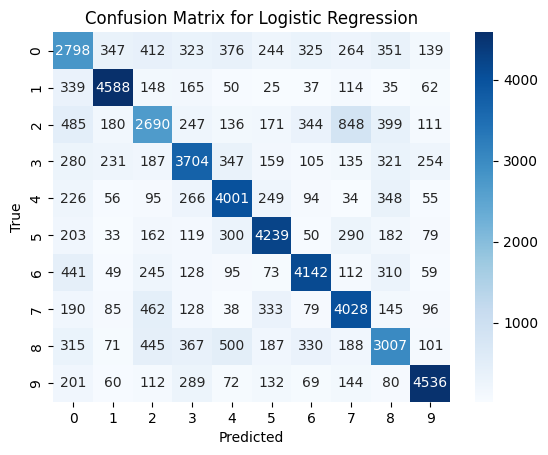

In [4]:
# Logistic Regression Model (using default parameters)
lr_model = LogisticRegression()

# Train the model on the training data
lr_model.fit(X_train_split, y_train_split)

# Make predictions on the validation data
y_pred_lr = lr_model.predict(X_val_split)

# Print the classification report for evaluation
print("Logistic Regression Test Report:\n", classification_report(y_val_split, y_pred_lr))

# Plot the Confusion Matrix
cm_lr = confusion_matrix(y_val_split, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Simple Naive Bayes Model

Naive Bayes Test Report:
               precision    recall  f1-score   support

           0       0.54      0.48      0.51      5579
           1       0.77      0.83      0.80      5563
           2       0.55      0.44      0.49      5611
           3       0.60      0.63      0.62      5723
           4       0.58      0.78      0.67      5424
           5       0.71      0.75      0.73      5657
           6       0.74      0.70      0.72      5654
           7       0.67      0.69      0.68      5584
           8       0.58      0.51      0.55      5511
           9       0.81      0.75      0.78      5695

    accuracy                           0.66     56001
   macro avg       0.66      0.66      0.65     56001
weighted avg       0.66      0.66      0.65     56001



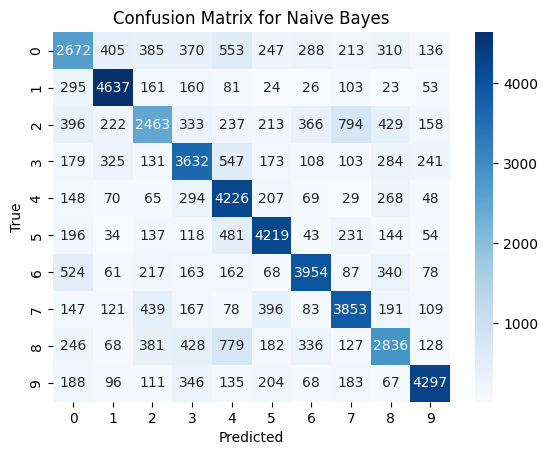

In [5]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the training data
nb_model.fit(X_train_split, y_train_split)

# Make predictions on the validation data
y_pred_nb = nb_model.predict(X_val_split)

# Evaluate the model
print("Naive Bayes Test Report:\n", classification_report(y_val_split, y_pred_nb))

# Plot Confusion Matrix
cm_nb = confusion_matrix(y_val_split, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Simple XGBoost Model

XGBoost Test Report:
               precision    recall  f1-score   support

           0       0.52      0.47      0.50      5579
           1       0.76      0.80      0.78      5563
           2       0.45      0.49      0.47      5611
           3       0.63      0.62      0.63      5723
           4       0.64      0.73      0.69      5424
           5       0.72      0.70      0.71      5657
           6       0.73      0.69      0.71      5654
           7       0.61      0.67      0.64      5584
           8       0.57      0.53      0.55      5511
           9       0.84      0.74      0.78      5695

    accuracy                           0.65     56001
   macro avg       0.65      0.65      0.65     56001
weighted avg       0.65      0.65      0.65     56001



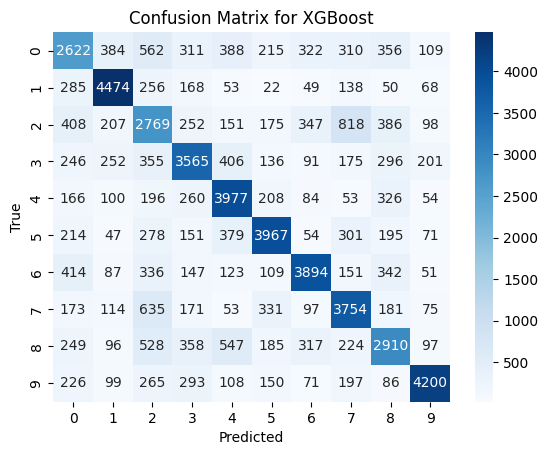

In [6]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_split)))

# Train the model on the training data
xgb_model.fit(X_train_split, y_train_split)

# Make predictions on the validation data
y_pred_xgb = xgb_model.predict(X_val_split)

# Evaluate the model
print("XGBoost Test Report:\n", classification_report(y_val_split, y_pred_xgb))

# Plot Confusion Matrix
cm_xgb = confusion_matrix(y_val_split, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [11]:
# Reshape the data to be 3D: (samples, timesteps, features)
X_train_3d = X_train_split.reshape(X_train_split.shape[0], 1, X_train_split.shape[1])  # 1 timestep per sample
X_val_3d = X_val_split.reshape(X_val_split.shape[0], 1, X_val_split.shape[1])          # 1 timestep per sample



In [16]:
# Reshape the 3D data to 2D for DNN
X_train_dnn = X_train_3d.reshape(X_train_3d.shape[0], X_train_3d.shape[2])  # (samples, features)
X_val_dnn = X_val_3d.reshape(X_val_3d.shape[0], X_val_3d.shape[2])          # (samples, features)


In [12]:
# Verify the shape of the reshaped data
print("Shape of X_train_3d:", X_train_3d.shape)
print("Shape of X_val_3d:", X_val_3d.shape)


Shape of X_train_3d: (224002, 1, 5000)
Shape of X_val_3d: (56001, 1, 5000)


Prepare Hyperparameter Grid

In [8]:
# Hyperparameter grid for Neural Networks
param_grid_nn = {
    'epochs': [10, 20],
    'batch_size': [64, 128],
    'units': [64, 128],  # Number of units in layers
    'dropout_rate': [0.2, 0.3],  # Dropout rate
    'learning_rate': [0.001, 0.01]
}

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Deep Neural Network (DNN)

In [19]:
# Define and train the Deep Neural Network model
def build_dnn_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train_dnn.shape[1]))  # Input shape matches the number of features
    model.add(Dropout(dropout_rate))  # Apply dropout to reduce overfitting
    model.add(Dense(len(np.unique(y_train_split)), activation='softmax'))  # Output layer with softmax activation
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the DNN model
dnn_model = build_dnn_model(128, 0.3, 0.001)
dnn_model.fit(X_train_dnn, y_train_split, epochs=20, batch_size=128, validation_data=(X_val_dnn, y_val_split), callbacks=[early_stopping])

# Predict and evaluate the DNN model
# Predict using the model (this returns probabilities for each class)
y_pred_dnn = dnn_model.predict(X_val_dnn)

# Convert the probabilities to class labels (taking the index with the highest probability)
y_pred_dnn_labels = y_pred_dnn.argmax(axis=1)

# Print the classification report with the correct predicted labels
print("DNN Test Report:\n", classification_report(y_val_split, y_pred_dnn_labels))



/home/P2510670/440_project/ml-nn-text-classification-comparison/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6520 - loss: 1.1565 - val_accuracy: 0.6786 - val_loss: 1.0039
Epoch 2/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6905 - loss: 0.9654 - val_accuracy: 0.6802 - val_loss: 0.9963
Epoch 3/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7015 - loss: 0.9204 - val_accuracy: 0.6792 - val_loss: 0.9975
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step
DNN Test Report:
               precision    recall  f1-score   support

           0       0.61      0.44      0.51      5579
           1       0.79      0.84      0.82      5563
           2       0.54      0.50      0.52      5611
           3       0.62      0.67      0.64      5723
           4       0.64      0.77      0.70      5424
           5       0.73      0.76      0.74      5657
           6       0.72      0.75      0.74      5654
           7       0.68      0.71      0.69      5584
           8       0.60      0.54      0.57      5511
      

Simple RNN

In [20]:
# Define and train the Simple RNN model
def build_rnn_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y_train_split)), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the Simple RNN model
rnn_model = build_rnn_model(128, 0.3, 0.001)
rnn_model.fit(X_train_3d, y_train_split, epochs=20, batch_size=128, validation_data=(X_val_3d, y_val_split), callbacks=[early_stopping])

# Predict and evaluate the Simple RNN model
y_pred_rnn = rnn_model.predict(X_val_3d)
y_pred_rnn_labels = y_pred_rnn.argmax(axis=1)
print("Simple RNN Test Report:\n", classification_report(y_val_split, y_pred_rnn_labels))


/home/P2510670/440_project/ml-nn-text-classification-comparison/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6492 - loss: 1.1573 - val_accuracy: 0.6783 - val_loss: 1.0041
Epoch 2/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6910 - loss: 0.9646 - val_accuracy: 0.6798 - val_loss: 0.9937
Epoch 3/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7021 - loss: 0.9197 - val_accuracy: 0.6794 - val_loss: 0.9975
Epoch 4/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7122 - loss: 0.8839 - val_accuracy: 0.6790 - val_loss: 1.0036
Epoch 5/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7214 - loss: 0.8503 - val_accuracy: 0.6766 - val_loss: 1.0123
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step
Simple RNN Test Report:
               precision    recall  f1-score   support

           0       0.59      0.46      0.52      5579
           1       0.78      0.85      0.82      5563
           2       0.56      0.47      0.51      5611
           3       0.64      0.66      0.65      5723
         

GRU (Gated Recurrent Unit)

In [21]:
# Define and train the GRU model
def build_gru_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(GRU(units, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y_train_split)), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the GRU model
gru_model = build_gru_model(128, 0.3, 0.001)
gru_model.fit(X_train_3d, y_train_split, epochs=20, batch_size=128, validation_data=(X_val_3d, y_val_split), callbacks=[early_stopping])

# Predict and evaluate the GRU model
y_pred_gru = gru_model.predict(X_val_3d)
y_pred_gru_labels = y_pred_gru.argmax(axis=1)
print("GRU Test Report:\n", classification_report(y_val_split, y_pred_gru_labels))


/home/P2510670/440_project/ml-nn-text-classification-comparison/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6459 - loss: 1.1727 - val_accuracy: 0.6788 - val_loss: 1.0034
Epoch 2/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6911 - loss: 0.9638 - val_accuracy: 0.6801 - val_loss: 0.9932
Epoch 3/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7024 - loss: 0.9188 - val_accuracy: 0.6801 - val_loss: 0.9950
Epoch 4/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7127 - loss: 0.8821 - val_accuracy: 0.6789 - val_loss: 1.0010
Epoch 5/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7220 - loss: 0.8498 - val_accuracy: 0.6776 - val_loss: 1.0103
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
GRU Test Report:
               precision    recall  f1-score   support

           0       0.55      0.49      0.52      5579
           1       0.80      0.84      0.82      5563
           2       0.56      0.47      0.51      5611
           3       0.65      0.65      0.65      5723
           4    

LSTM (Long Short-Term Memory)

In [22]:
# Define and train the LSTM model
def build_lstm_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y_train_split)), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the LSTM model
lstm_model = build_lstm_model(128, 0.3, 0.001)
lstm_model.fit(X_train_3d, y_train_split, epochs=20, batch_size=128, validation_data=(X_val_3d, y_val_split), callbacks=[early_stopping])

# Predict and evaluate the LSTM model
y_pred_lstm = lstm_model.predict(X_val_3d)
y_pred_lstm_labels = y_pred_lstm.argmax(axis=1)
print("LSTM Test Report:\n", classification_report(y_val_split, y_pred_lstm_labels))


/home/P2510670/440_project/ml-nn-text-classification-comparison/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6458 - loss: 1.1969 - val_accuracy: 0.6788 - val_loss: 1.0083
Epoch 2/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6899 - loss: 0.9702 - val_accuracy: 0.6807 - val_loss: 0.9952
Epoch 3/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7015 - loss: 0.9237 - val_accuracy: 0.6810 - val_loss: 0.9947
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step
LSTM Test Report:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52      5579
           1       0.81      0.83      0.82      5563
           2       0.57      0.46      0.51      5611
           3       0.61      0.68      0.64      5723
           4       0.65      0.76      0.70      5424
           5       0.72      0.77      0.74      5657
           6       0.74      0.74      0.74      5654
           7       0.66      0.72      0.69      5584
           8       0.60      0.54      0.57      5511
    

Bidirectional Simple RNN

In [23]:
# Define and train the Bidirectional Simple RNN model
def build_bi_rnn_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(units, activation='relu'), input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(np.unique(y_train_split)), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the Bidirectional Simple RNN model
bi_rnn_model = build_bi_rnn_model(128, 0.3, 0.001)
bi_rnn_model.fit(X_train_3d, y_train_split, epochs=20, batch_size=128, validation_data=(X_val_3d, y_val_split), callbacks=[early_stopping])

# Predict and evaluate the Bidirectional Simple RNN model
y_pred_bi_rnn = bi_rnn_model.predict(X_val_3d)
y_pred_bi_rnn_labels = y_pred_bi_rnn.argmax(axis=1)
print("Bidirectional Simple RNN Test Report:\n", classification_report(y_val_split, y_pred_bi_rnn_labels))


NameError: name 'Bidirectional' is not defined